In [1]:
# Import libraries and packages
from kmembert.utils import Config
from kmembert.models import TransformerAggregator
from kmembert.dataset import PredictionsDataset
from torch.utils.data import DataLoader
from collections import defaultdict
from kmembert.dataset import PredictionsDataset
from kmembert.models import TransformerAggregator
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, roc_curve, r2_score, mean_squared_error
from kmembert.utils import pretty_time, printc, create_session, save_json, get_label_threshold, get_error, time_survival_to_label, collate_fn
from kmembert.utils import create_session, get_label_threshold, collate_fn
from time import time

import seaborn as sns
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import argparse
import torch
import sys

In [2]:
# Load the pre-trained model
resume = "kmembert-T2"
config = Config()
config.resume = resume

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters of the pre-trained T2 model
nhead, num_layers, out_dim, time_dim = 8, 4, 2, 8

# Init model
model = TransformerAggregator(device, config, nhead, num_layers, out_dim, time_dim)

# Load the model
model.resume(config)

Resuming with model at kmembert-T2...
Successfully loaded



In [3]:
# argparse part to test the model
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("-d", "--data_folder", type=str, default="ehr", 
    help="data folder name")
parser.add_argument("-a", "--aggregator", type=str, default="transformer", 
    help="aggregator name", choices=['conflation', 'sanity_check', 'sanity_check_transformer', 'transformer'])
parser.add_argument("-r", "--resume", type=str, default = "kmembert-base", 
    help="result folder in which the saved checkpoint will be reused")
parser.add_argument("-e", "--epochs", type=int, default=2, 
    help="number of epochs")
parser.add_argument("-nr", "--nrows", type=int, default=None, 
    help="maximum number of samples for training and validation")
parser.add_argument("-k", "--print_every_k_batch", type=int, default=1, 
    help="prints training loss every k batch")
parser.add_argument("-dt", "--days_threshold", type=int, default=365, 
    help="days threshold to convert into classification task")
parser.add_argument("-lr", "--learning_rate", type=float, default=1e-4, 
    help="model learning rate")
parser.add_argument("-wg", "--weight_decay", type=float, default=0, 
    help="the weight decay for L2 regularization")
parser.add_argument("-p", "--patience", type=int, default=4, 
    help="number of decreasing accuracy epochs to stop the training")
parser.add_argument("-me", "--max_ehrs", type=int, default=4, 
    help="maximum nusmber of ehrs to be used for multi ehrs prediction")
parser.add_argument("-nh", "--nhead", type=int, default=8, 
    help="number of transformer heads")
parser.add_argument("-nl", "--num_layers", type=int, default=4, 
    help="number of transformer layers")
parser.add_argument("-od", "--out_dim", type=int, default=2, 
    help="transformer out_dim (1 regression or 2 density)")
parser.add_argument("-td", "--time_dim", type=int, default=8, 
    help="transformer time_dim")

args = parser.parse_args("")

> DEVICE:  cpu
> ROOT:    c:\Users\DIPIAZZA\Documents\CLB Projet\Projet1\Test Load BERTS\KmemBERT
> SESSION: c:\Users\DIPIAZZA\Documents\CLB Projet\Projet1\Test Load BERTS\KmemBERT\results\ipykernel_launcher_22-05-04_17h26m49s
output hidden states: True
hb is None
Dans le premier if

Loading camembert and its tokenizer...
if config.resume from health_bert.py
Resuming with model at kmembert-base...


  0%|          | 0/10 [00:00<?, ?it/s]

Successfully loaded


Computing Health Bert predictions...


100%|██████████| 10/10 [01:36<00:00,  9.63s/it]


size: 376 bytes
Successfully computed 264 Health Bert outputs

    Validation | MAE: 586 days - Global average loss: -2.170663 - Time elapsed: 0m4s

    Best loss so far
    Saving model state...
    Saving predictions...
    Error while computing ROC curve
    (Ended validation)



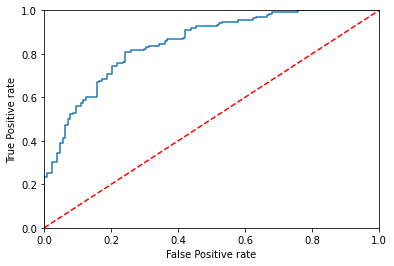

In [4]:
# Load data and test the model
path_dataset, path_result, device, config = create_session(args)

assert (768 + args.time_dim) % args.nhead == 0, f'd_model (i.e. 768 + time_dim) must be divisible by nhead. Found time_dim {args.time_dim} and nhead {args.nhead}'

config.label_threshold = get_label_threshold(config, path_dataset)

dataset = PredictionsDataset(path_dataset, config, output_hidden_states=True, device=device, train=False)
loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

model.config.mode = "density"

test_losses = []
validation = True
model.eval()
predictions, test_labels, stds, noigr = [], [], [], []
test_start_time = time()

total_loss = 0
for i, (*data, labels) in enumerate(loader):
    noigr.append(id)

    loss, outputs = model.step(*data, labels)
    
    if model.mode == 'classif':
        predictions += torch.softmax(outputs, dim=1).argmax(axis=1).tolist()
    elif model.mode == 'regression':
        predictions += outputs.flatten().tolist()
    elif model.mode == 'density':
        mus, log_vars = outputs
        predictions += mus.tolist()
        stds += torch.exp(log_vars/2).tolist()
    elif model.mode == 'multi':
        if model.config.mode == 'density' or (model.config.mode == 'classif' and model.out_dim == 2):
            mu, log_var = outputs
            predictions.append(mu.item())
            stds.append(torch.exp(log_var/2).item())
        else:
            predictions.append(outputs.item())
    else:
        raise ValueError(f'Mode {model.mode} unknown')
    
    test_labels += labels.tolist()
    total_loss += loss.item()

mean_loss = total_loss/(config.batch_size*len(loader))

if test_losses is not None:
    test_losses.append(mean_loss)

error = get_error(test_labels, predictions, config.mean_time_survival)
printc(f"    {'Validation' if validation else 'Test'} | MAE: {int(error)} days - Global average loss: {mean_loss:.6f} - Time elapsed: {pretty_time(time()-test_start_time)}\n", 'RESULTS')

if validation:
    if mean_loss < model.best_loss:
        model.best_loss = mean_loss
        printc('    Best loss so far', 'SUCCESS')
        print('    Saving model state...')
        state = {
            'model': model.state_dict(),
            'optimizer': model.optimizer.state_dict(),
            #'scheduler': model.scheduler.state_dict(),
            'best_loss': model.best_loss,
            'epoch': 0,
            'tokenizer': model.tokenizer if hasattr(model, 'tokenizer') else None
        }
        #torch.save(state, os.path.join(path_result, './checkpoint.pth'))
        model.early_stopping = 0
    else: 
        model.early_stopping += 1
        #return mean_loss

print('    Saving predictions...')
#save_json(path_result, "test", {"labels": test_labels, "predictions": predictions, "stds": stds, "noigr": noigr})

predictions = np.array(predictions)
test_labels = np.array(test_labels)

if len(stds) > 0:
    n_points = 20
    resize_factor = 20
    gaussian_predictions = np.random.normal(predictions, np.array(stds)/resize_factor, size=(n_points, len(predictions))).flatten().clip(0, 1)
    associated_labels = np.tile(test_labels, n_points)
    sns.kdeplot(
        data={'Predictions': gaussian_predictions, 'Labels': associated_labels}, 
        y='Predictions', x='Labels', clip=((0, 1), (0, 1)),
        fill=True, thresh=0, levels=100, cmap="mako",
    )
    plt.title('Prediction distributions over labels')
    plt.savefig(os.path.join(path_result, "correlations_distributions.png"))
    plt.close()

    plt.scatter(test_labels, stds)
    plt.xlabel("Label")
    plt.ylabel("Standard Deviations")
    plt.xlim(0, 1)
    plt.ylim(0, max(stds))
    plt.title("Labels and corresponding standard deviations")
    plt.savefig(os.path.join(path_result, "stds.png"))
    plt.close()

all_errors = get_error(test_labels, predictions, config.mean_time_survival, mean=False)

# MAE / Labels
plt.scatter(test_labels, all_errors)
plt.xlabel("Labels")
plt.ylabel("MAE")
plt.xlim(0, 1)
plt.ylim(0, max(all_errors))
plt.title("MAE distribution")
plt.savefig(os.path.join(path_result, "mae_distribution.png"))
plt.close()

# Predictions / Labels + Scatter Plot
plt.scatter(test_labels, predictions)
xy_line = np.arange(0, 2, 1).tolist()
plt.plot(xy_line, xy_line, color="red", label="y=x")
plt.xlabel("Labels")
plt.ylabel("Predictions")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc="upper left")
plt.title("Predictions / Labels correlation")
plt.savefig(os.path.join(path_result, "correlations.png"))
plt.close()

errors_dict = defaultdict(list)
for mae, label in zip(all_errors.tolist(), test_labels.tolist()):
    quantile = np.floor(label*10)
    errors_dict[quantile].append(mae)
ape_per_quantile = sorted([(quantile, np.mean(l), np.std(l)) for quantile, l in errors_dict.items()])


metrics = {}
metrics["correlation"] = np.corrcoef(predictions, test_labels)[0,1]
metrics["label_mae"] = np.mean(np.abs(predictions - test_labels))
metrics["r2_score"] = r2_score(test_labels, predictions)

# Pour chaque tranche de jours: 30, 90, ... 1 an.
for days in [30,90,180,270,360]:
    # Jour changé en tant que label
    label = time_survival_to_label(days, config.mean_time_survival)
    # Si predictions>=label => 1, sinon 0.
    # Autrement dit: Si a l'echelle, le patient survit plus de 30 jours ou pas.
    bin_predictions = (predictions >= label).astype(int)
    bin_labels = (test_labels >= label).astype(int)
    
    days = f"{days} days"
    metrics[days] = {}
    metrics[days]['accuracy'] = accuracy_score(bin_labels, bin_predictions)
    metrics[days]['balanced_accuracy'] = balanced_accuracy_score(bin_labels, bin_predictions)
    metrics[days]['f1_score'] = f1_score(bin_labels, bin_predictions, average=None).tolist()
    
try:
    # Error when only one class (in practice it happens only on the `ehr` sanity-check dataset)
    
    # ROC Curve for treshold = 0.5
    threshold = 0.5
    bin_labels = (test_labels >= threshold).astype(int)
    metrics['auc'] = roc_auc_score(bin_labels, predictions).tolist()
    fpr, tpr, _ = roc_curve(bin_labels, predictions)

    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], 'r--')
    plt.xlabel("False Positive rate")
    plt.ylabel("True Positive rate")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title("ROC curve for threshold: " + threshold)
    plt.savefig(os.path.join(path_result, "roc_curve.png"))
    plt.close()
except:
    printc("    Error while computing ROC curve", "WARNING")

if not validation:
    print("Classification metrics:\n", metrics)

# Compute more metrics
mse = mean_squared_error(predictions, test_labels)

save_json(path_result, 'results', 
    {'mae': error,
    'mse': mse,
    'mean_loss': mean_loss,
    'metrics': metrics,
    'ape_per_quantile': ape_per_quantile})

print(f"    (Ended {'validation' if validation else 'testing'})\n")

In [5]:
##########################################